In [13]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from docplex.mp.advmodel import AdvModel
from matplotlib import style
#style.use('dark_background') #si ton vs-code est noir

À faire:

- chercher les 30 peaks annuels => DONE
- aggreger la puissance installée + utiliser les coûts de PV => DONE
- commencer à implémenter le modèle

# Data preparation

In [125]:
data_2013 = pd.read_csv("./data/2012-2013 Solar home electricity data v2.csv", header = 1)

In [126]:
data_2013

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,CL,1/07/2012,1.250,1.250,1.250,1.263,0.131,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.081,NaN
1,1,3.78,2076,GC,1/07/2012,0.855,0.786,0.604,0.544,0.597,...,0.374,0.447,0.549,0.136,0.288,0.181,0.651,0.090,0.068,NaN
2,1,3.78,2076,GG,1/07/2012,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,CL,2/07/2012,1.250,1.250,1.125,0.000,0.925,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.069,NaN
4,1,3.78,2076,GC,2/07/2012,0.309,0.082,0.059,0.097,0.290,...,0.353,0.464,0.229,0.811,0.222,0.306,1.034,0.136,0.067,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268552,300,3.36,2086,GC,29/06/2013,0.171,0.832,0.440,0.745,0.149,...,0.383,0.404,0.367,0.398,0.350,0.228,0.170,0.139,0.171,NaN
268553,300,3.36,2086,GG,29/06/2013,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
268554,300,3.36,2086,CL,30/06/2013,2.501,2.475,2.491,2.508,2.490,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.468,NaN
268555,300,3.36,2086,GC,30/06/2013,0.150,0.158,0.157,0.137,0.163,...,0.625,0.595,0.695,0.646,0.581,0.458,0.472,0.732,0.297,NaN


In [127]:
#count the number of NA (non-actual) in 'Row Quality' column:
print(f"number of NA (non-actual) row: {data_2013['Row Quality'].count()}")

number of NA (non-actual) row: 0


In [128]:
#store customer infos
data_cust = data_2013.groupby(by='Customer')
cust_info = pd.DataFrame()
cust_info['Customer ID'] = data_cust['Customer'].first()
cust_info['Generator Capacity'] = data_cust['Generator Capacity'].first()
cust_info['Postcode'] = data_cust['Postcode'].first()

In [135]:
#rearrange dataframe
meltdate = data_2013.melt(id_vars = ['Customer', 'Consumption Category', 'date'], value_vars = data_2013.columns[5:53], var_name = 'time', value_name = 'power')
unstk = meltdate.pivot_table('power', ['Customer', 'date', "time"], 'Consumption Category')
unstk.reset_index(level = [0, 1, 2], inplace = True)
unstk['Timestamp'] = pd.to_datetime(unstk['date'] + unstk['time'], format='%d/%m/%Y%H:%M')
unstk.pop('date')
unstk.pop('time')

0           0:00
1           0:30
2          10:00
3          10:30
4          11:00
           ...  
5252107     7:30
5252108     8:00
5252109     8:30
5252110     9:00
5252111     9:30
Name: time, Length: 5252112, dtype: object

In [153]:
df = unstk.groupby(by = 'Timestamp').sum()
df = df.resample('60min').sum()
df.reset_index(inplace=True)
df.pop('Customer')
df['NET'] = df['GC'] + df['CL'] - df['GG']
df

Consumption Category,Timestamp,CL,GC,GG,NET
0,2012-07-01 00:00:00,181.636,186.140,0.039,367.737
1,2012-07-01 01:00:00,152.692,151.654,0.076,304.270
2,2012-07-01 02:00:00,96.712,129.242,0.112,225.842
3,2012-07-01 03:00:00,44.895,125.389,0.291,169.993
4,2012-07-01 04:00:00,19.457,118.000,0.202,137.255
...,...,...,...,...,...
8755,2013-06-30 19:00:00,4.895,402.192,0.037,407.050
8756,2013-06-30 20:00:00,7.563,378.843,0.046,386.360
8757,2013-06-30 21:00:00,8.716,342.074,0.049,350.741
8758,2013-06-30 22:00:00,40.530,300.159,0.027,340.662


# Data visualization:

## Load profiles

Two letter code each meaning the following:

GC = General Consumption for electricity supplied all the time
(primary tariff, either inclining block or time of use rates),
excluding solar generation and controlled load supply

CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)

GG = Gross Generation for electricity generated by the solar
system with a gross metering configuration, measured separately
to household loads

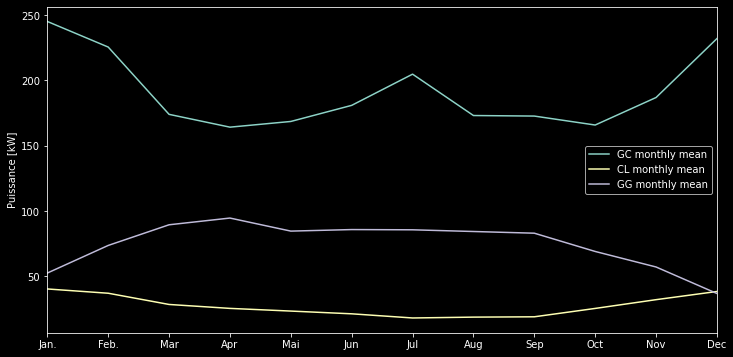

In [149]:
def plot_months(df):
    groupby_month = df.groupby(pd.Grouper(key='Timestamp', freq='M'))
    data_month = [group for _,group in groupby_month]
    GC_month, CL_month, GG_month = list(), list(), list()
    for month in data_month:
        GC_month.append(month['GC'].mean())
        CL_month.append(month['CL'].mean())
        GG_month.append(month['GG'].mean())

    fig = plt.figure(figsize=(12,6))
    lin = np.linspace(0, 12, 12)
    plt.plot(lin, GC_month, label = 'GC monthly mean')
    plt.plot(lin, CL_month, label = 'CL monthly mean')
    plt.plot(lin, GG_month, label = 'GG monthly mean')

    plt.legend()
    plt.xlim([0, 12])
    plt.xticks(lin, ['Jan.', 'Feb.', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Puissance [kW]')
    plt.show()

plot_months(df)

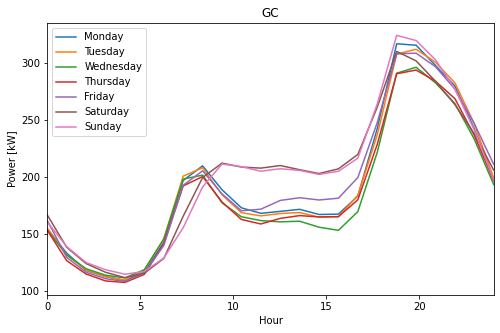

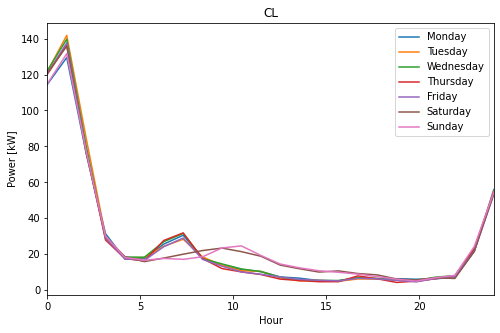

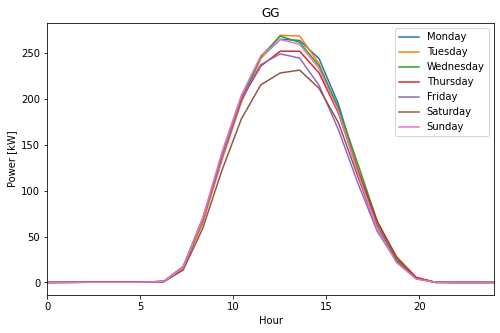

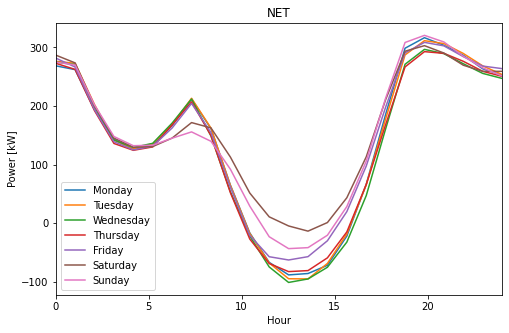

In [18]:
def plot_week(df, profil = 'GC'):
    #analysis per day
    day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    #seasons_name = ['Winter', 'Summer', 'Interseason']
    fig = plt.figure(figsize=(8, 5))
    data_day = df.groupby(df['Timestamp'].dt.weekday)
    list_day = [day for (_, day) in data_day]
    for i, day in enumerate(list_day):
        data_hour = day.groupby(day['Timestamp'].dt.hour).mean()
        if profil in ['GC', 'CL', 'GG', 'NET']:
            power_half = data_hour[profil]
        else:
            print("Wrong profil")
            return
        plt.plot(np.linspace(0, 24, 24), power_half, label = day_of_week[i])
    plt.xlim([0, 24])
    plt.xlabel('Hour')
    plt.ylabel('Power [kW]')
    plt.legend(loc = 0)
    plt.title(profil)
    plt.savefig(f"week_trend_{profil}")
    plt.show()

plot_week(df, 'GC')
plot_week(df, 'CL')
plot_week(df, 'GG')
plot_week(df, 'NET')

In [28]:
#peaks in year:
df_sort = df.sort_values(by = 'NET', ascending = False)
df_sort.reset_index(inplace=True)

peak_dates = []
peak_idx = [] #10 dates with biggest peaks
n_peak_day = 10
i = 0
while len(peak_dates) < n_peak_day and i < 30:
    date = df_sort['Timestamp'].iloc[i].date()
    if not date in peak_dates:
        peak_dates.append(date)
        peak_idx.append(i)
    i += 1
df_peak = pd.DataFrame([df_sort.iloc[i] for i in peak_idx])

Consumption Category,index,Timestamp,CL,GC,GG,NET
0,4604,2013-01-08 20:00:00,2.462,737.412,1.599,738.275
3,4843,2013-01-18 19:00:00,1.115,676.490,4.939,672.666
9,8586,2013-06-23 18:00:00,6.764,526.387,0.018,533.133
10,979,2012-08-10 19:00:00,7.503,525.262,0.023,532.742
12,91,2012-07-04 19:00:00,11.366,518.054,0.081,529.339
13,522,2012-07-22 18:00:00,11.910,503.560,0.043,515.427
14,18,2012-07-01 18:00:00,13.838,499.330,0.021,513.147
15,8634,2013-06-25 18:00:00,6.798,506.323,0.033,513.088
16,763,2012-08-01 19:00:00,15.888,497.059,0.067,512.880
17,739,2012-07-31 19:00:00,4.374,507.114,0.076,511.412


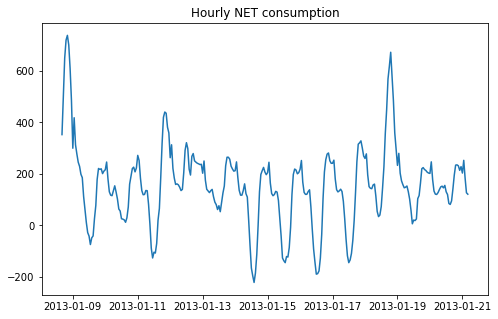

In [32]:
#pour la présentation:
fig = plt.figure(figsize=(8, 5))
plt.plot(df['Timestamp'].loc[4600:4900], df['NET'].loc[4600:4900])
plt.title("Hourly NET consumption")
plt.savefig("hourly_snapshot")
plt.show()

## Customer infos:

In [148]:
print(f"total installed capacity is: {cust_info['Generator Capacity'].sum()} kW")
print(f"average installed capacity is: {cust_info['Generator Capacity'].mean()} kW")

total installed capacity is: 504.99 kW
average installed capacity is: 1.6832999999999994 kW


# Model

In [2]:
class Microgrid : 
    
    def __init__(self, timestep, N_timesteps, interest_rate, **parameters):
        
        # Inputs: 
        #   timestep : duration of each timestep
        #   N_timesteps : the number of timesteps
        #   interest_rate : interest rate of the project for the actualization of costs
        #   **parameters : other parameters
        
        self.__timestep = timestep
        self.__N_timesteps = N_timesteps
        self.__i = interest_rate
        
        self.__P_PV = parameters["P_PV"] # Installed power of PV of reference microgid
        self.__C_inv_PV = parameters["C_inv_PV"] # Cost of PV per kW
        
        self.__E_bat_max = parameters["E_bat_max"]
        self.__DoD = parameters["DoD"]
        self.__eff_bat = parameters["eff_bat"]
        self.__P_bat_max = parameters["P_bat_max"]
        self.__C_inv_bat = parameters["C_inv_bat"]
        self.__lifespan_bat = parameters["lifespan_bat"]
        self.__N_cycle = parameters["N_cycle"]
        self.__E_bat_0 = parameters["E_bat_0"] # Initial state of battery
        
        self.__E_bat_min = (1-self.__DoD)*self.__E_bat_max
        self.__CRF = (self.__i * (1 + self.__i) ** 25) / ((1 + self.__i) ** 25 - 1)
        self.__CRF_bat = 1 + 1/(1+self.__i)**10 + 1/(1+self.__i)**20
        
    def Optim(self):
        
        # Inputs: 
        #   
        # Output:
        #
        
        # Define the model
        model = AdvModel(name="microgrid")
        
        # PV variable
        ratio_PV = model.continuous_var(lb= 0, 
                                        ub= 100, 
                                        name= 'ratio_PV')
        
        '''------------ ENERGY STORAGE SYSTEM ------------'''
        
        # Number of batteries
        n_bat = model.integer_var(lb = 0, ub=100, name= 'n_bat')
        
        # State of charge of batteries
        E_bat = model.continuous_var_list(self.__N_timesteps, 
                                          lb = 0, 
                                          ub = 10000, 
                                          name = 'E_bat')
        # State of charge constraints
        model.add_constraints(E_bat[i] >= n_bat * self.__E_bat_min for i in range(self.__N_timesteps))
        model.add_constraints(E_bat[i] <= n_bat * self.__E_bat_max for i in range(self.__N_timesteps))
        
        
        # Charge power
        P_bat_ch = model.continuous_var_list(self.__N_timesteps, 
                                          lb = 0, 
                                          ub = 10000, 
                                          name = 'P_bat_ch')
        
        # Discharge power
        P_bat_dis = model.continuous_var_list(self.__N_timesteps, 
                                          lb = 0, 
                                          ub = 10000, 
                                          name = 'P_bat_dis')
        
        # State of charge (==1 if charging)
        s_ch = model.binary_var_list(self.__N_timesteps, name = 's_ch') 
        
        # State of discharge (==1 if discharging)
        s_dis = model.binary_var_list(self.__N_timesteps, name = 's_dis') 
        
        # Charging and discharging constraints
        model.add_constraints(P_i <= s_i * self.__P_bat_max * n_bat for P_i, s_i in zip(P_bat_ch, s_ch)) #À LINÉARISER
        model.add_constraints(P_i <= s_i * self.__P_bat_max * n_bat for P_i, s_i in zip(P_bat_dis, s_dis)) #À LINÉARISER 
        model.add_constraints(s_ch_i + s_dis_i <= 1 for s_ch_i, s_dis_i in zip(s_ch, s_dis))
        
        # System equilibrium 
        model.add_constraint(E_bat[0] == self.__E_bat_0)
        model.add_constraints(E_bat[i] == E_bat[i-1] + self.__eff_bat * P_bat_ch[i] * self.__timestep - P_bat_dis[i] * self.__timestep / self.__eff_bat for i in range(1, self.__N_timesteps))
        
        ''' 
        # variable inutile
        P_bat = model.continuous_var_list(N_timesteps, 
                                          lb = 0, 
                                          ub = self.__P_bat_max, 
                                          name = 'P_bat')
        
        model.add_constraints(Pi == Ei / timestep for Pi, Ei in zip(P_bat, E_bat))
        '''
        
        '''-------------------- COSTS --------------------'''
        
        C_ch = self.__C_inv_bat * sum(P_bat_ch) / 2 / self.__N_cycle
        C_dis = self.__C_inv_bat * sum(P_bat_dis) / 2 / self.__N_cycle
        
        
        CAPEX = self.__CRF * (self.__C_inv_PV * self.__P_PV * ratio_PV + n_bat * self.__C_inv_bat * self.__CRF_bat)
        
        OPEX = 0
        
        MTN = 0
        
        obj = CAPEX + OPEX + MTN
        
        '''-------------- SOLVING THE MODEL --------------'''
        
        model.minimize(obj)
        solution = model.solve()
        
        sol_P_PV = solution.get_value(ratio_PV) * self.__P_PV
        sol_n_bat = solution.get_value(n_bat)
        
        
        return sol_P_PV, sol_n_bat
        
        
    